<a href="https://colab.research.google.com/github/alfianhid/Feature-Extraction-Gray-Level-Co-occurrence-Matrix-GLCM-with-Python/blob/main/Feature_Extraction_Gray_Level_Co_occurrence_Matrix_(GLCM)_with_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1) Kita akan menggunakan library 'os' untuk membaca nama file dari folder, dan library 'cv2' (OpenCV) untuk melakukan pemrosesan citra**

In [ ]:
import numpy as np 
import cv2 
import os
import re

# -------------------- Utility function ------------------------
def normalize_label(str_):
    str_ = str_.replace(" ", "")
    str_ = str_.translate(str_.maketrans("","", "()"))
    str_ = str_.split("_")
    return ''.join(str_[:2])

def normalize_desc(folder, sub_folder):
    text = folder + " - " + sub_folder 
    text = re.sub(r'\d+', '', text)
    text = text.replace(".", "")
    text = text.strip()
    return text

def print_progress(val, val_len, folder, sub_folder, filename, bar_size=10):
    progr = "#"*round((val)*bar_size/val_len) + " "*round((val_len - (val))*bar_size/val_len)
    if val == 0:
        print("", end = "\n")
    else:
        print("[%s] folder : %s/%s/ ----> file : %s" % (progr, folder, sub_folder, filename), end="\r")
        

# -------------------- Load Dataset ------------------------
 
dataset_dir = "/content/drive/MyDrive/DATASET" 

imgs = [] #list image matrix 
labels = []
descs = []
for folder in os.listdir(dataset_dir):
    for sub_folder in os.listdir(os.path.join(dataset_dir, folder)):
        sub_folder_files = os.listdir(os.path.join(dataset_dir, folder, sub_folder))
        len_sub_folder = len(sub_folder_files) - 1
        for i, filename in enumerate(sub_folder_files):
            img = cv2.imread(os.path.join(dataset_dir, folder, sub_folder, filename))
            
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            h, w = gray.shape
            ymin, ymax, xmin, xmax = h//3, h*2//3, w//3, w*2//3
            crop = gray[ymin:ymax, xmin:xmax]
            
            resize = cv2.resize(crop, (0,0), fx=0.5, fy=0.5)
            
            imgs.append(resize)
            labels.append(normalize_label(os.path.splitext(filename)[0]))
            descs.append(normalize_desc(folder, sub_folder))
            
            print_progress(i, len_sub_folder, folder, sub_folder, filename)

**2) Keseluruhan dataset citra daun akan tersimpan pada list 'imgs' dan nama daun disimpan pada list 'labels'. Kita dapat preview salah satu citra dengan cara berikut**

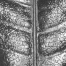

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(imgs[5])

**3) Selanjutnya kita dapat mencari matrix GLCM dan metric texture keseluruhan citra daun dengan menggunakan fungsi greycomatrix() dan greycoprops() pada library Scikit-Image**

In [ ]:
from skimage.feature import greycomatrix, greycoprops

# ----------------- calculate greycomatrix() & greycoprops() for angle 0, 45, 90, 135 ----------------------------------
def calc_glcm_all_agls(img, label, props, dists=[5], agls=[0, np.pi/4, np.pi/2, 3*np.pi/4], lvl=256, sym=True, norm=True):
    
    glcm = greycomatrix(img, 
                        distances=dists, 
                        angles=agls, 
                        levels=lvl,
                        symmetric=sym, 
                        normed=norm)
    feature = []
    glcm_props = [propery for name in props for propery in greycoprops(glcm, name)[0]]
    for item in glcm_props:
            feature.append(item)
    feature.append(label) 
    
    return feature


# ----------------- call calc_glcm_all_agls() for all properties ----------------------------------
properties = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']

glcm_all_agls = []
for img, label in zip(imgs, labels): 
    glcm_all_agls.append(
            calc_glcm_all_agls(img, 
                                label, 
                                props=properties)
                            )
 
columns = []
angles = ['0', '45', '90','135']
for name in properties :
    for ang in angles:
        columns.append(name + "_" + ang)
        
columns.append("label")

**4) Selanjutnya kita ubah format data glcm_features dari list menjadi Dataframe menggunakan library pandas**

In [ ]:
import pandas as pd 

# Create the pandas DataFrame for GLCM features data
glcm_df = pd.DataFrame(glcm_all_agls, 
                      columns = columns)

glcm_df.head(15)

,dissimilarity_0,dissimilarity_45,dissimilarity_90,dissimilarity_135,correlation_0,correlation_45,correlation_90,correlation_135,homogeneity_0,homogeneity_45,homogeneity_90,homogeneity_135,contrast_0,contrast_45,contrast_90,contrast_135,ASM_0,ASM_45,ASM_90,ASM_135,energy_0,energy_45,energy_90,energy_135,label
0,6.945604,6.631113,4.832091,6.852758,0.451720,0.482434,0.725584,0.469734,0.190978,0.205142,0.231599,0.192076,104.887481,98.913111,51.415797,101.415193,0.001949,0.002004,0.002371,0.001961,0.044144,0.044761,0.048696,0.044282,jambu1GRAYC
1,8.568058,7.317378,6.747889,8.901405,0.347678,0.523747,0.564154,0.343938,0.167020,0.187366,0.179366,0.139533,157.265524,114.526015,101.611773,158.622008,0.001486,0.001642,0.001594,0.001333,0.038549,0.040516,0.039926,0.036505,jambu2GRAYC
2,5.108048,5.038762,3.274714,5.018991,0.641410,0.670960,0.898662,0.692801,0.225383,0.221336,0.278620,0.215296,60.467213,56.285900,19.544461,52.003902,0.003352,0.003520,0.003929,0.003301,0.057899,0.059330,0.062683,0.057454,jambu3GRAYC
3,7.681818,6.331165,4.583209,6.643080,0.170933,0.368438,0.706236,0.395651,0.214456,0.236072,0.251631,0.218759,143.130899,108.309834,49.489816,103.457336,0.003516,0.003883,0.003861,0.003467,0.059293,0.062315,0.062140,0.058883,jambu4GRAYC
4,6.701689,6.039802,4.300546,6.475286,0.380918,0.452372,0.723213,0.455338,0.201916,0.221474,0.239759,0.179263,121.137357,106.911811,54.076006,106.333247,0.002266,0.002401,0.002533,0.002157,0.047602,0.048999,0.050326,0.046445,jambu5GRAYC
5,39.567312,42.037981,36.546200,40.573101,0.344789,0.261661,0.402319,0.308987,0.025514,0.021513,0.033100,0.024430,2449.936413,2731.565036,2248.355440,2559.065817,0.000169,0.000175,0.000175,0.000176,0.012997,0.013234,0.013217,0.013248,mangga1GRAYC
6,21.248634,20.373049,15.598112,21.664932,0.394672,0.440111,0.712337,0.386133,0.064679,0.064411,0.080584,0.061806,877.216344,815.080125,447.425733,900.295005,0.000420,0.000425,0.000468,0.000437,0.020492,0.020613,0.021641,0.020901,mangga2GRAYC
7,23.688773,23.139958,19.968455,23.340010,0.679093,0.705738,0.783783,0.684737,0.062572,0.058134,0.067319,0.064012,1107.535271,1017.881374,754.058867,1077.703694,0.000371,0.000394,0.000403,0.000402,0.019253,0.019862,0.020082,0.020057,mangga3GRAYC
8,31.254347,36.582726,31.728763,32.450312,0.385286,0.181319,0.285737,0.333208,0.058684,0.058477,0.069617,0.057810,1933.382017,2570.233091,2204.178838,2092.857180,0.000362,0.000359,0.000415,0.000369,0.019021,0.018948,0.020367,0.019217,mangga4GRAYC
9,17.724789,18.348595,14.715847,18.867066,0.694301,0.673658,0.793261,0.660221,0.102366,0.090989,0.105956,0.095279,700.084451,747.999480,479.137109,783.537721,0.000724,0.000720,0.000834,0.000768,0.026916,0.026825,0.028888,0.027705,mangga5GRAYC
